In [1]:
%load_ext autoreload
%autoreload 2
import os
from pylab import *


import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
import xarray as xr
import pathlib
from scipy.signal import convolve2d
import copy
from scipy.io import loadmat

def conv2(x, y, mode='same'):
    return np.rot90(convolve2d(np.rot90(x, 2), np.rot90(y, 2), mode=mode), 2)

import drama.geo as sargeo
import drama.utils as drtls
from stereoid.oceans import (
    RetrievalModel,
    ObsGeo,
    SceneGenerator,
    RadarModel,
    #read_GoM_scenario,
    FwdModelRIM,
)
from drama.geo.derived_geo import BistaticRadarGeometry
from stereoid.oceans.read_scenario_California import read_scenario_California
import stereoid.sar_performance as strsarperf
import stereoid.utils.config as st_config
import stereoid.oceans.visualization.geo_plot as gplt

# Load results and inputs

In [2]:
paths = st_config.parse(config_file_path=pathlib.Path("/Users/marcelmac/Data/Harmony/PAR/mac_defaults.cfg"),section="Paths")
# Unpack the paths read from user.cfg. If user.cfg is not found user_defaults.cfg is used.
main_dir = paths["main"]
datadir = paths["data"]
pardir = paths["par"]
resultsdir = paths["results"]
scn_file = 'California/ocean_lionel.mat'
scn_dir = '/Users/marcelmac/Data/OceanModels/'
swan_file = 'hsCal_T01.mat'
swan_dir = os.path.join(resultsdir,'SWAN/California')
l2_dir_lut_trad = os.path.join(resultsdir,'OceanE2E/Scenarios/California/T01/L2_traditional/LUT')
l2_dir_swan_noiwa = os.path.join(resultsdir,'OceanE2E/Scenarios/California/T01/L2_noiwa/SWAN_noneq')
l2_dir_swan_noimacs = os.path.join(resultsdir,'OceanE2E/Scenarios/California/T01/L2_noimacs/SWAN_noneq')
l2_dir_swan_iwaimacs = os.path.join(resultsdir,'OceanE2E/Scenarios/California/T01/L2_iwaimacs/SWAN_noneq')
filename_lut='L2_All_obs_California_T01_P10_LUT_002_375_x_150_390_y_150_600_rot_-14_10.nc'
filename_swan='L2_All_obs_California_T01_P10_SWAN_noneq_002_375_x_150_390_y_150_600_rot_-14_10.nc'
#scndir = os.path.join(datadir, "Ocean/Scenarios")
#plotdir = os.path.join(os.path.join(resultsdir, "SWB_plots"), "California")
plotdir = '/Users/marcelmac/Documents/Papers/ScientificWorkbenchPart1/FiguresL2/'
os.makedirs(plotdir, exist_ok=True)
scnname='California'
#/Users/marcelmac/Data/Harmony/RESULTS/OceanE2E/Scenarios/California/T01/LUT

/Users/marcelmac/PythonProjects/stereoid /Users/marcelmac/Data/Harmony/PAR/mac_defaults.cfg


In [3]:
xrL2_lut_trad = xr.open_dataset(os.path.join(l2_dir_lut_trad,filename_lut))
xrL2_swan_noiwa = xr.open_dataset(os.path.join(l2_dir_swan_noiwa,filename_swan))
xrL2_swan_noimacs = xr.open_dataset(os.path.join(l2_dir_swan_noimacs,filename_swan))
xrL2_swan_iwaimacs = xr.open_dataset(os.path.join(l2_dir_swan_iwaimacs,filename_swan))
cali_data, dx = read_scenario_California(os.path.join(scn_dir, scn_file), smp_out=1e3, rot_angle=-14)
tsc_crp = cali_data['tsc'][150:600, 150:390]
u10s_crp = cali_data['wnd'][150:600, 150:390]
sst_crp = cali_data['sst'][150:600, 150:390]
xrInput = xr.Dataset({"U10s_norm":(("az", "gr"), np.linalg.norm(cali_data["wnd"], axis=-1)[150:600, 150:390]),
                      "TSC_norm":(("az", "gr"), np.linalg.norm(cali_data["tsc"], axis=-1)[150:600, 150:390]),
                      "U10s":(("az", "gr","di"), cali_data["wnd"][150:600, 150:390]),
                      "TSC":(("az", "gr","di"), cali_data["tsc"][150:600, 150:390]),
#                      "SST":(("az","gr"), cali_data["sst"]),
#                      "Hs":(("az","gr"), hs_data["Hsig"]),
                      "latitude":(("az","gr"), cali_data["lat"][150:600, 150:390]),
                      "longitude":(("az","gr"), cali_data["lon"][150:600, 150:390])})

# Show model inputs

In [4]:
lon_range = [xrL2_swan_iwaimacs.longitude.values[2:-2].min(), xrL2_swan_iwaimacs.longitude.values[2:-2].max()]
lat_range = [xrL2_swan_iwaimacs.latitude.values[2:-2].min(), xrL2_swan_iwaimacs.latitude.values[2:-2].max()]

#gplt.geoplot(xrInput, "TSC", sat='HA', cmap='Blues',bvarname="TSC",vmin=0, vmax=1,cblabelcolor='black',
             #lat_range=lat_range, lon_range=lon_range, txt='TSC',figsize=(5, 10))


### Stress-equivalent wind vectors


/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_81219/8575904.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('cividis', 10)


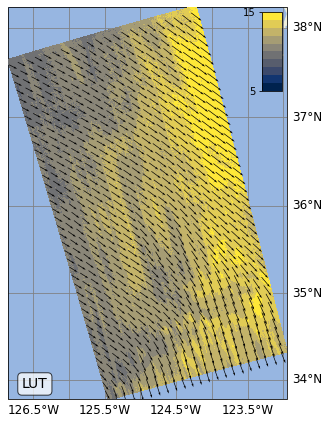

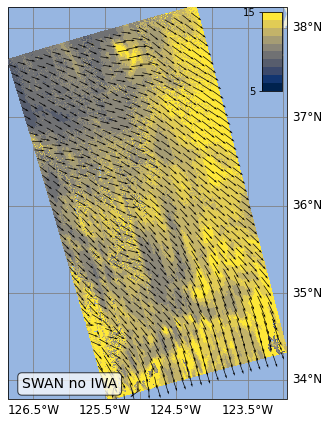

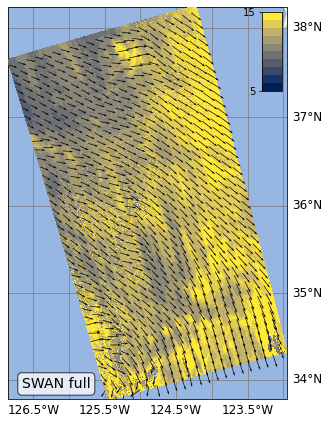

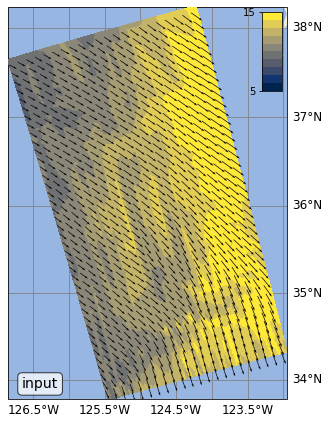

In [5]:
cmap=cm.get_cmap('cividis', 10)
# traditional lut
u10s_lut = np.stack([xrL2_lut_trad.wnd_u, xrL2_lut_trad.wnd_v], axis=-1)
u10s_lut = gplt.rot_vect(u10s_lut, northing_rad=-np.radians(14+90+10))
xrL2_lut_trad["U10s"] = (['az', 'gr'], np.linalg.norm(u10s_lut, axis=-1))
gplt.geoquiver(xrL2_lut_trad, u10s_lut, decim=11, basedata=xrL2_lut_trad, bvarname='U10s', sat='S1', figsize=(5, 10), 
               vmin=0, vmax=0.1, cmap="gray_r", 
               bmin=5, bmax=15, bcmap=cmap, alpha=0.5, scale=300, widths=1,txt='LUT', 
               db=False,lon_range=lon_range, lat_range=lat_range, cblabelcolor='black', base_is_same=True)
plt.savefig(os.path.join(plotdir,('%s_wind_traditional_lut.png' % (scnname))), dpi=300,bbox_inches='tight')

# SWAN without IWA
u10s_swan = np.stack([xrL2_swan_noiwa.wnd_u, xrL2_swan_noiwa.wnd_v], axis=-1)
u10s_swan = gplt.rot_vect(u10s_swan, northing_rad=-np.radians(14+90+10))
xrL2_swan_noiwa["U10s"] = (['az', 'gr'], np.linalg.norm(u10s_swan, axis=-1))
gplt.geoquiver(xrL2_swan_noiwa, u10s_swan, decim=11, basedata=xrL2_swan_noiwa, bvarname='U10s', sat='S1', figsize=(5, 10), 
               vmin=0, vmax=0.1, cmap="gray_r", 
               bmin=5, bmax=15, bcmap=cmap, alpha=0.5, scale=300, widths=1,txt='SWAN no IWA', 
               db=False,lon_range=lon_range, lat_range=lat_range, cblabelcolor='black', base_is_same=True)
plt.savefig(os.path.join(plotdir,('%s_wind_noiwa_swan.png' % (scnname))), dpi=300,bbox_inches='tight')

# SWAN without iMACS
u10s_swan = np.stack([xrL2_swan_noimacs.wnd_u, xrL2_swan_noimacs.wnd_v], axis=-1)
u10s_swan = gplt.rot_vect(u10s_swan, northing_rad=-np.radians(14+90+10))
xrL2_swan_noimacs["U10s"] = (['az', 'gr'], np.linalg.norm(u10s_swan, axis=-1))
gplt.geoquiver(xrL2_swan_noimacs, u10s_swan, decim=11, basedata=xrL2_swan_noimacs, bvarname='U10s', sat='S1', figsize=(5, 10), 
               vmin=0, vmax=0.1, cmap="gray_r", 
               bmin=5, bmax=15, bcmap=cmap, alpha=0.5, scale=300, widths=1,txt='SWAN no iMACS', 
               db=False,lon_range=lon_range, lat_range=lat_range, cblabelcolor='black', base_is_same=True)
plt.savefig(os.path.join(plotdir,('%s_wind_noimacs_swan.png' % (scnname))), dpi=300,bbox_inches='tight')

# SWAN with IWA and iMACS
u10s_swan = np.stack([xrL2_swan_iwaimacs.wnd_u, xrL2_swan_iwaimacs.wnd_v], axis=-1)
u10s_swan = gplt.rot_vect(u10s_swan, northing_rad=-np.radians(14+90+10))
xrL2_swan_iwaimacs["U10s"] = (['az', 'gr'], np.linalg.norm(u10s_swan, axis=-1))
gplt.geoquiver(xrL2_swan_iwaimacs, u10s_swan, decim=11, basedata=xrL2_swan_iwaimacs, bvarname='U10s', sat='S1', figsize=(5, 10), 
               vmin=0, vmax=0.1, cmap="gray_r", 
               bmin=5, bmax=15, bcmap=cmap, alpha=0.5, scale=300, widths=1,txt='SWAN full', 
               db=False,lon_range=lon_range, lat_range=lat_range, cblabelcolor='black', base_is_same=True)
plt.savefig(os.path.join(plotdir,('%s_wind_iwaimacs_swan.png' % (scnname))), dpi=300,bbox_inches='tight')

# input
u10s = np.stack([xrInput['U10s'][:,:,0], xrInput['U10s'][:,:,1]], axis=-1)
u10s = gplt.rot_vect(u10s, northing_rad=-np.radians(14+90+10))
gplt.geoquiver(xrInput, u10s, decim=11, basedata=xrInput, bvarname='U10s_norm', sat='S1', figsize=(5, 10), 
               vmin=0, vmax=0.01, cmap="gray_r", 
               bmin=5, bmax=15, bcmap=cmap, alpha=0.5, scale=300, widths=1,txt='input', 
               db=False,lon_range=lon_range, lat_range=lat_range, cblabelcolor='black', base_is_same=True)
plt.savefig(os.path.join(plotdir,('%s_input_wind.png' % (scnname))), dpi=300,bbox_inches='tight')

/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_81219/3856732732.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('RdBu', 11)


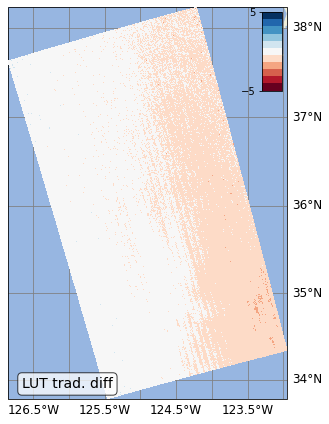

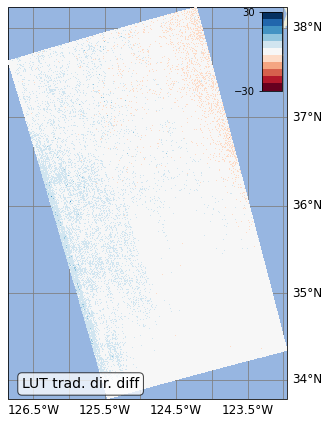

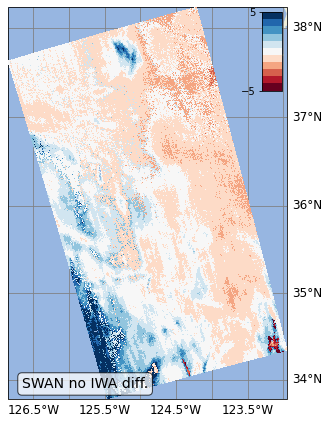

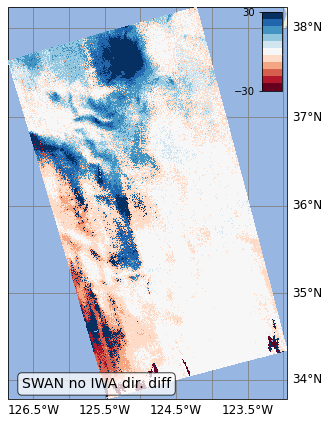

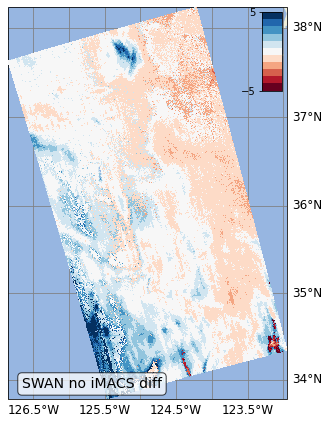

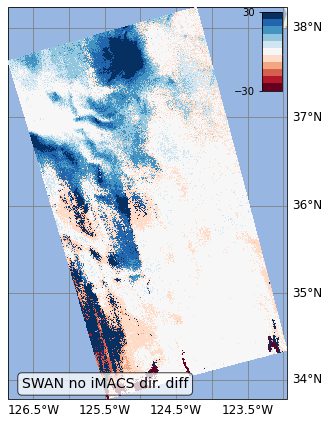

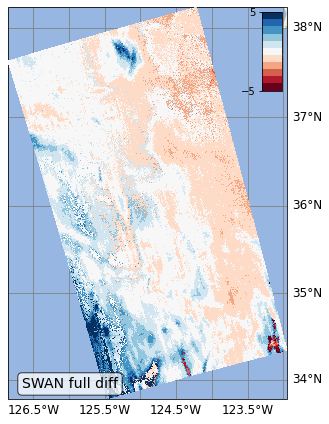

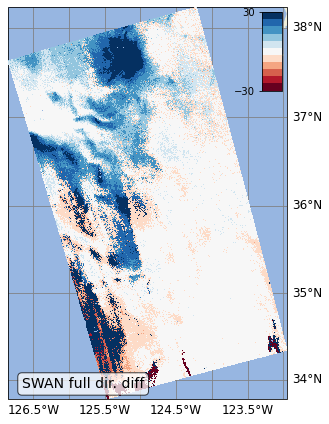

In [6]:
cmap=cm.get_cmap('RdBu', 11)
# traditional lut
u=xrL2_lut_trad['wnd_u'].values
v=xrL2_lut_trad['wnd_v'].values
xrL2_lut_trad["wnd_norm_dif"]=(['az', 'gr'], np.sqrt(u**2+v**2)-np.sqrt(u10s_crp[:,:,0]**2+u10s_crp[:,:,1]**2))
gplt.geoplot(xrL2_lut_trad, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-5, vmax=5,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['LUT trad. diff'])
plt.savefig(os.path.join(plotdir,('%s_wind_traditional_lut_diff.png' % (scnname))), dpi=300,bbox_inches='tight')

xrL2_lut_trad["wnd_norm_dif"]=(['az', 'gr'], np.degrees(np.arctan2(v,u)-np.arctan2(u10s_crp[:,:,1],u10s_crp[:,:,0])))
gplt.geoplot(xrL2_lut_trad, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-30, vmax=30,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['LUT trad. dir. diff'])
plt.savefig(os.path.join(plotdir,('%s_wind_traditional_lut_diff_dir.png' % (scnname))), dpi=300,bbox_inches='tight')

# SWAN without iwa
u=xrL2_swan_noiwa['wnd_u'].values
v=xrL2_swan_noiwa['wnd_v'].values
xrL2_swan_noiwa["wnd_norm_dif"]=(['az', 'gr'], np.sqrt(u**2+v**2)-np.sqrt(u10s_crp[:,:,0]**2+u10s_crp[:,:,1]**2))
gplt.geoplot(xrL2_swan_noiwa, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-5, vmax=5,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN no IWA diff.'])
plt.savefig(os.path.join(plotdir,('%s_wind_noiwa_swan_diff.png' % (scnname))), dpi=300,bbox_inches='tight')

xrL2_swan_noiwa["wnd_norm_dif"]=(['az', 'gr'], np.degrees(np.arctan2(v,u)-np.arctan2(u10s_crp[:,:,1],u10s_crp[:,:,0])))
gplt.geoplot(xrL2_swan_noiwa, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-30, vmax=30,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN no IWA dir. diff'])
plt.savefig(os.path.join(plotdir,('%s_wind_noiwa_swan_diff_dir.png' % (scnname))), dpi=300,bbox_inches='tight')

# SWAN without iMACS
u=xrL2_swan_noimacs['wnd_u'].values
v=xrL2_swan_noimacs['wnd_v'].values
xrL2_swan_noimacs["wnd_norm_dif"]=(['az', 'gr'], np.sqrt(u**2+v**2)-np.sqrt(u10s_crp[:,:,0]**2+u10s_crp[:,:,1]**2))
gplt.geoplot(xrL2_swan_noimacs, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-5, vmax=5,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN no iMACS diff'])
plt.savefig(os.path.join(plotdir,('%s_wind_noimacs_swan_diff.png' % (scnname))), dpi=300,bbox_inches='tight')

xrL2_swan_noimacs["wnd_norm_dif"]=(['az', 'gr'], np.degrees(np.arctan2(v,u)-np.arctan2(u10s_crp[:,:,1],u10s_crp[:,:,0])))
gplt.geoplot(xrL2_swan_noimacs, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-30, vmax=30,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN no iMACS dir. diff'])
plt.savefig(os.path.join(plotdir,('%s_wind_noimacs_swan_diff_dir.png' % (scnname))), dpi=300,bbox_inches='tight')


# SWAN with IWA and iMACS
u=xrL2_swan_iwaimacs['wnd_u'].values
v=xrL2_swan_iwaimacs['wnd_v'].values
xrL2_swan_iwaimacs["wnd_norm_dif"]=(['az', 'gr'], np.sqrt(u**2+v**2)-np.sqrt(u10s_crp[:,:,0]**2+u10s_crp[:,:,1]**2))
gplt.geoplot(xrL2_swan_iwaimacs, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-5, vmax=5,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN full diff'])
plt.savefig(os.path.join(plotdir,('%s_wind_iwaimacs_swan_diff.png' % (scnname))), dpi=300,bbox_inches='tight')

xrL2_swan_iwaimacs["wnd_norm_dif"]=(['az', 'gr'], np.degrees(np.arctan2(v,u)-np.arctan2(u10s_crp[:,:,1],u10s_crp[:,:,0])))
gplt.geoplot(xrL2_swan_iwaimacs, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-30, vmax=30,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN full dir. diff'])
plt.savefig(os.path.join(plotdir,('%s_wind_iwaimacs_swan_diff_dir.png' % (scnname))), dpi=300,bbox_inches='tight')



### Surface current

/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_81219/942048135.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('plasma', 10)


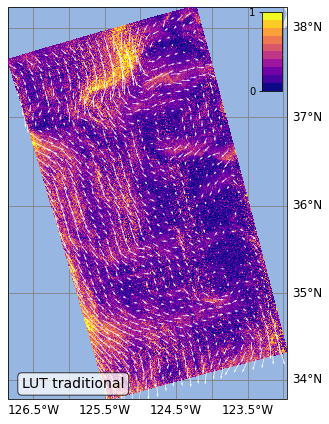

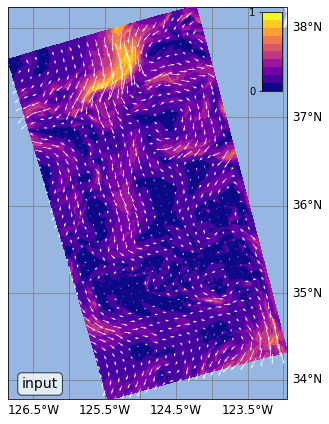

In [7]:
cmap=cm.get_cmap('plasma', 10)
# traditional lut
u10s_lut = np.stack([xrL2_lut_trad.tsc_u, xrL2_lut_trad.tsc_v], axis=-1)
u10s_lut = gplt.rot_vect(u10s_lut, northing_rad=-np.radians(14+90+10))
xrL2_lut_trad["U10s"] = (['az', 'gr'], np.linalg.norm(u10s_lut, axis=-1))
gplt.geoquiver(xrL2_lut_trad, u10s_lut, decim=11, basedata=xrL2_lut_trad, bvarname='U10s', sat='S1', figsize=(5, 10), 
               vmin=0, vmax=0.01, cmap="gray", 
               bmin=0, bmax=1, bcmap=cmap, alpha=0.5, scale=10, widths=1,txt='LUT traditional', 
               db=False,lon_range=lon_range, lat_range=lat_range, cblabelcolor='black', base_is_same=True)
plt.savefig(os.path.join(plotdir,('%s_tsc_traditional_lut.png' % (scnname))), dpi=300,bbox_inches='tight')


# SWAN no IWA
u10s_swan = np.stack([xrL2_swan_noiwa.tsc_u, xrL2_swan_noiwa.tsc_v], axis=-1)
u10s_swan = gplt.rot_vect(u10s_swan, northing_rad=-np.radians(14+90+10))
xrL2_swan_noiwa["U10s"] = (['az', 'gr'], np.linalg.norm(u10s_swan, axis=-1))
gplt.geoquiver(xrL2_swan_noiwa, u10s_swan, decim=11, basedata=xrL2_swan_noiwa, bvarname='U10s', sat='S1', figsize=(5, 10), 
               vmin=0, vmax=0.01, cmap="gray", 
               bmin=0, bmax=1, bcmap=cmap, alpha=0.5, scale=10, widths=1,txt='SWAN no IWA', 
               db=False,lon_range=lon_range, lat_range=lat_range, cblabelcolor='black', base_is_same=True)
plt.savefig(os.path.join(plotdir,('%s_tsc_noiwa_swan.png' % (scnname))), dpi=300,bbox_inches='tight')

# SWAN no iMACS
u10s_swan = np.stack([xrL2_swan_noimacs.tsc_u, xrL2_swan_noimacs.tsc_v], axis=-1)
u10s_swan = gplt.rot_vect(u10s_swan, northing_rad=-np.radians(14+90+10))
xrL2_swan_noimacs["U10s"] = (['az', 'gr'], np.linalg.norm(u10s_swan, axis=-1))
gplt.geoquiver(xrL2_swan_noimacs, u10s_swan, decim=11, basedata=xrL2_swan_noimacs, bvarname='U10s', sat='S1', figsize=(5, 10), 
               vmin=0, vmax=0.01, cmap="gray", 
               bmin=0, bmax=1, bcmap=cmap, alpha=0.5, scale=10, widths=1,txt='SWAN no iMACS', 
               db=False,lon_range=lon_range, lat_range=lat_range, cblabelcolor='black', base_is_same=True)
plt.savefig(os.path.join(plotdir,('%s_tsc_noimacs_swan.png' % (scnname))), dpi=300,bbox_inches='tight')

# SWAN with IWA and iMACS
u10s_swan = np.stack([xrL2_swan_iwaimacs.tsc_u, xrL2_swan_iwaimacs.tsc_v], axis=-1)
u10s_swan = gplt.rot_vect(u10s_swan, northing_rad=-np.radians(14+90+10))
xrL2_swan_iwaimacs["U10s"] = (['az', 'gr'], np.linalg.norm(u10s_swan, axis=-1))
gplt.geoquiver(xrL2_swan_iwaimacs, u10s_swan, decim=11, basedata=xrL2_swan_iwaimacs, bvarname='U10s', sat='S1', figsize=(5, 10), 
               vmin=0, vmax=0.01, cmap="gray", 
               bmin=0, bmax=1, bcmap=cmap, alpha=0.5, scale=10, widths=1,txt='SWAN full', 
               db=False,lon_range=lon_range, lat_range=lat_range, cblabelcolor='black', base_is_same=True)
plt.savefig(os.path.join(plotdir,('%s_tsc_iwaimacs_swan.png' % (scnname))), dpi=300,bbox_inches='tight')

# input
TSC = np.stack([xrInput['TSC'][:,:,0], xrInput['TSC'][:,:,1]], axis=-1)
TSC = gplt.rot_vect(TSC, northing_rad=-np.radians(14+90+10))
gplt.geoquiver(xrInput, TSC, decim=11, basedata=xrInput, bvarname='TSC_norm', sat='S1', figsize=(5, 10), 
               vmin=0, vmax=0.01, cmap="gray", 
               bmin=0, bmax=1, bcmap=cmap, alpha=0.5, scale=10, widths=1,txt='input', 
               db=False,lon_range=lon_range, lat_range=lat_range, cblabelcolor='black', base_is_same=True)
plt.savefig(os.path.join(plotdir,('%s_input_tsc.png' % (scnname))), dpi=300,bbox_inches='tight')

/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_81219/252194181.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('RdBu', 11)
/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_81219/252194181.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2=cm.get_cmap('PuOr', 11)


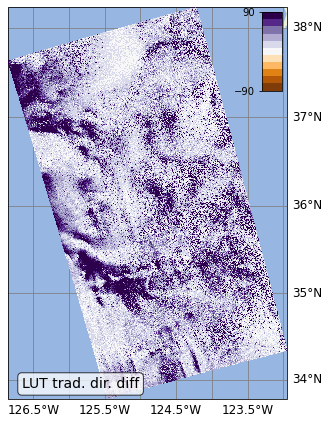

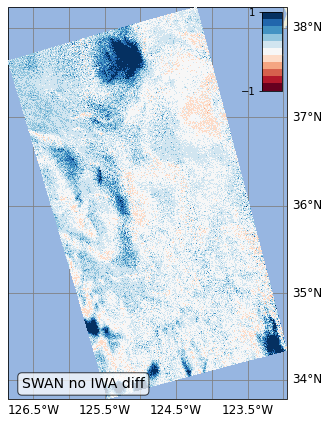

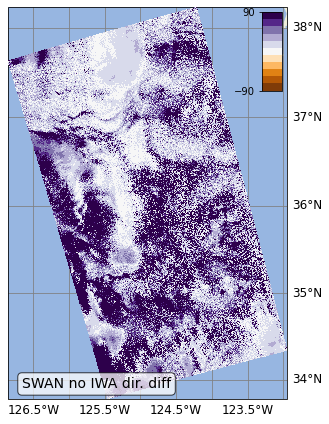

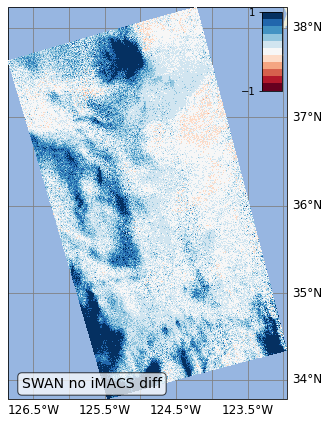

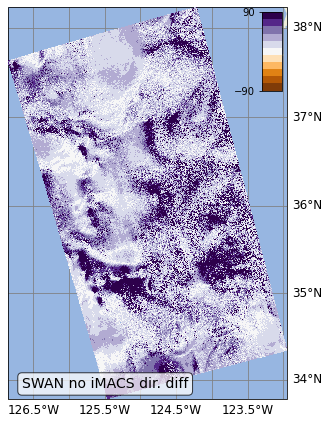

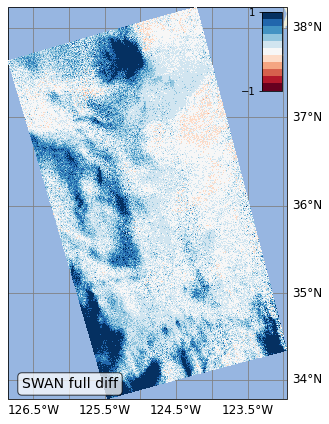

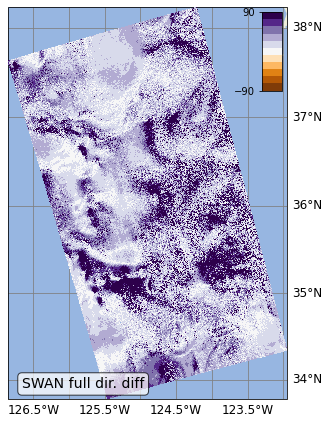

In [8]:
cmap=cm.get_cmap('RdBu', 11)
cmap2=cm.get_cmap('PuOr', 11)
# traditional lut
u=xrL2_lut_trad['tsc_u'].values
v=xrL2_lut_trad['tsc_v'].values
xrL2_lut_trad["wnd_norm_dif"]=(['az', 'gr'], np.sqrt(u**2+v**2)-np.sqrt(tsc_crp[:,:,0]**2+tsc_crp[:,:,1]**2))
gplt.geoplot(xrL2_lut_trad, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-1, vmax=1,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['LUT trad. diff'])
plt.savefig(os.path.join(plotdir,('%s_tsc_traditional_lut_diff.png' % (scnname))), dpi=300,bbox_inches='tight')

dangle=np.degrees(np.arccos((tsc_crp[:,:,0]*u+tsc_crp[:,:,1]*v)/np.sqrt(u**2+v**2)/np.sqrt(tsc_crp[:,:,0]**2+tsc_crp[:,:,1]**2)))
#dangle[np.sqrt(tsc_crp[:,:,0]**2+tsc_crp[:,:,1]**2) < 0.1]=NaN
xrL2_lut_trad["wnd_norm_dif"]=(['az', 'gr'], dangle)
gplt.geoplot(xrL2_lut_trad, "wnd_norm_dif", sat='S1', cmap=cmap2,vmin=-90, vmax=90,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['LUT trad. dir. diff'])
plt.savefig(os.path.join(plotdir,('%s_tsc_traditional_lut_diff_dir.png' % (scnname))), dpi=300,bbox_inches='tight')

# SWAN no IWA
u=xrL2_swan_noiwa['tsc_u'].values
v=xrL2_swan_noiwa['tsc_v'].values
xrL2_swan_noiwa["wnd_norm_dif"]=(['az', 'gr'], np.sqrt(u**2+v**2)-np.sqrt(tsc_crp[:,:,0]**2+tsc_crp[:,:,1]**2))
gplt.geoplot(xrL2_swan_noiwa, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-1, vmax=1,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN no IWA diff'])
plt.savefig(os.path.join(plotdir,('%s_tsc_noiwa_swan_diff.png' % (scnname))), dpi=300,bbox_inches='tight')

dangle=np.degrees(np.arccos((tsc_crp[:,:,0]*u+tsc_crp[:,:,1]*v)/np.sqrt(u**2+v**2)/np.sqrt(tsc_crp[:,:,0]**2+tsc_crp[:,:,1]**2)))
#dangle[np.sqrt(tsc_crp[:,:,0]**2+tsc_crp[:,:,1]**2) < 0.1]=NaN
xrL2_swan_noiwa["wnd_norm_dif"]=(['az', 'gr'], dangle)
gplt.geoplot(xrL2_swan_noiwa, "wnd_norm_dif", sat='S1', cmap=cmap2,vmin=-90, vmax=90,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN no IWA dir. diff'])
plt.savefig(os.path.join(plotdir,('%s_tsc_noiwa_swan_diff_dir.png' % (scnname))), dpi=300,bbox_inches='tight')

# SWAN no iMACS
u=xrL2_swan_noimacs['tsc_u'].values
v=xrL2_swan_noimacs['tsc_v'].values
xrL2_swan_noimacs["wnd_norm_dif"]=(['az', 'gr'], np.sqrt(u**2+v**2)-np.sqrt(tsc_crp[:,:,0]**2+tsc_crp[:,:,1]**2))
gplt.geoplot(xrL2_swan_noimacs, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-1, vmax=1,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN no iMACS diff'])
plt.savefig(os.path.join(plotdir,('%s_tsc_noimacs_swan_diff.png' % (scnname))), dpi=300,bbox_inches='tight')

dangle=np.degrees(np.arccos((tsc_crp[:,:,0]*u+tsc_crp[:,:,1]*v)/np.sqrt(u**2+v**2)/np.sqrt(tsc_crp[:,:,0]**2+tsc_crp[:,:,1]**2)))
#dangle[np.sqrt(tsc_crp[:,:,0]**2+tsc_crp[:,:,1]**2) < 0.1]=NaN
xrL2_swan_noimacs["wnd_norm_dif"]=(['az', 'gr'], dangle)
gplt.geoplot(xrL2_swan_noimacs, "wnd_norm_dif", sat='S1', cmap=cmap2,vmin=-90, vmax=90,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN no iMACS dir. diff'])
plt.savefig(os.path.join(plotdir,('%s_tsc_noimacs_swan_diff_dir.png' % (scnname))), dpi=300,bbox_inches='tight')

# SWAN with IWA and iMACS
u=xrL2_swan_iwaimacs['tsc_u'].values
v=xrL2_swan_iwaimacs['tsc_v'].values
xrL2_swan_iwaimacs["wnd_norm_dif"]=(['az', 'gr'], np.sqrt(u**2+v**2)-np.sqrt(tsc_crp[:,:,0]**2+tsc_crp[:,:,1]**2))
gplt.geoplot(xrL2_swan_iwaimacs, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-1, vmax=1,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN full diff'])
plt.savefig(os.path.join(plotdir,('%s_tsc_iwaimacs_swan_diff.png' % (scnname))), dpi=300,bbox_inches='tight')

dangle=np.degrees(np.arccos((tsc_crp[:,:,0]*u+tsc_crp[:,:,1]*v)/np.sqrt(u**2+v**2)/np.sqrt(tsc_crp[:,:,0]**2+tsc_crp[:,:,1]**2)))
#dangle[np.sqrt(tsc_crp[:,:,0]**2+tsc_crp[:,:,1]**2) < 0.1]=NaN
xrL2_swan_iwaimacs["wnd_norm_dif"]=(['az', 'gr'], dangle)
gplt.geoplot(xrL2_swan_iwaimacs, "wnd_norm_dif", sat='S1', cmap=cmap2,vmin=-90, vmax=90,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN full dir. diff'])
plt.savefig(os.path.join(plotdir,('%s_tsc_iwaimacs_swan_diff_dir.png' % (scnname))), dpi=300,bbox_inches='tight')





/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_81219/2205383987.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('RdBu', 11)
/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_81219/2205383987.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2=cm.get_cmap('RdBu', 11)


0.09733332194303439
0.20353828893587286
0.13145604438362402
0.31843787903298554
0.1617347082239436
0.4376020340744371
0.1617347082239436
0.4376020340744371


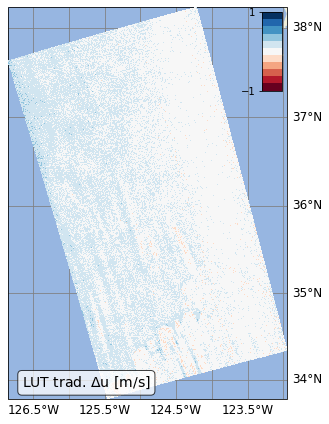

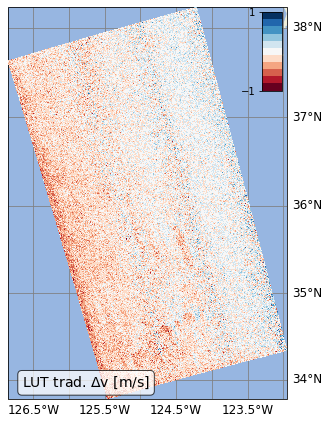

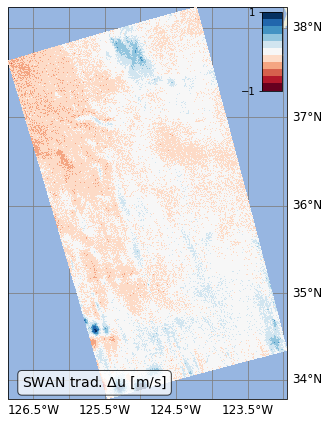

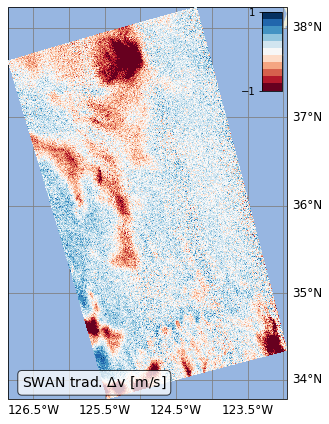

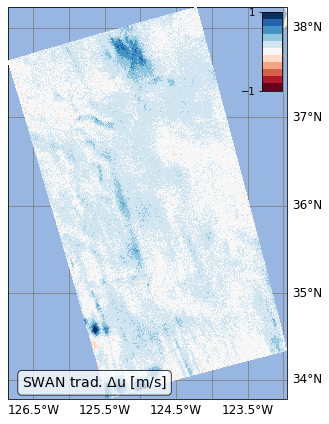

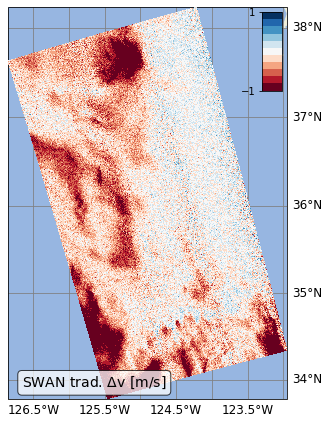

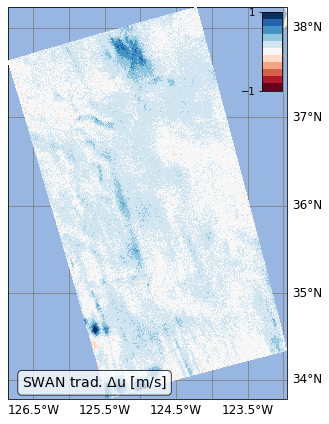

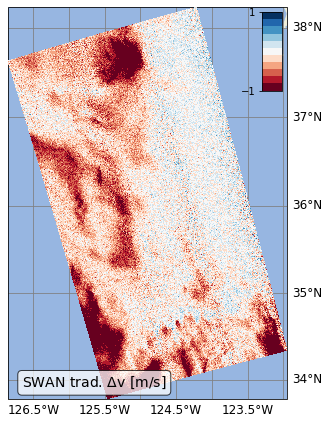

In [9]:
cmap=cm.get_cmap('RdBu', 11)
cmap2=cm.get_cmap('RdBu', 11)
# traditional lut
u=xrL2_lut_trad['tsc_u'].values
v=xrL2_lut_trad['tsc_v'].values
xrL2_lut_trad["wnd_norm_dif"]=(['az', 'gr'], u-tsc_crp[:,:,0])
print(np.sqrt(np.mean((u-tsc_crp[:,:,0])**2)))
gplt.geoplot(xrL2_lut_trad, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-1, vmax=1,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['LUT trad. $\Delta$u [m/s]'])
plt.savefig(os.path.join(plotdir,('%s_tsc_traditional_lut_diffu.png' % (scnname))), dpi=300,bbox_inches='tight')

xrL2_lut_trad["wnd_norm_dif"]=(['az', 'gr'], v-tsc_crp[:,:,1])
print(np.sqrt(np.mean((v-tsc_crp[:,:,1])**2)))
gplt.geoplot(xrL2_lut_trad, "wnd_norm_dif", sat='S1', cmap=cmap2,vmin=-1, vmax=1,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['LUT trad. $\Delta$v [m/s]'])
plt.savefig(os.path.join(plotdir,('%s_tsc_traditional_lut_diffv.png' % (scnname))), dpi=300,bbox_inches='tight')

# SWAN no IWA
u=xrL2_swan_noiwa['tsc_u'].values
v=xrL2_swan_noiwa['tsc_v'].values
xrL2_swan_noiwa["wnd_norm_dif"]=(['az', 'gr'], u-tsc_crp[:,:,0])
print(np.sqrt(np.mean((u-tsc_crp[:,:,0])**2)))
gplt.geoplot(xrL2_swan_noiwa, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-1, vmax=1,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN trad. $\Delta$u [m/s]'])
plt.savefig(os.path.join(plotdir,('%s_tsc_noiwa_swan_diffu.png' % (scnname))), dpi=300,bbox_inches='tight')

xrL2_swan_noiwa["wnd_norm_dif"]=(['az', 'gr'], v-tsc_crp[:,:,1])
print(np.sqrt(np.mean((v-tsc_crp[:,:,1])**2)))
gplt.geoplot(xrL2_swan_noiwa, "wnd_norm_dif", sat='S1', cmap=cmap2,vmin=-1, vmax=1,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN trad. $\Delta$v [m/s]'])
plt.savefig(os.path.join(plotdir,('%s_tsc_noiwa_swan_diffv.png' % (scnname))), dpi=300,bbox_inches='tight')

# SWAN no iMACS
u=xrL2_swan_noimacs['tsc_u'].values
v=xrL2_swan_noimacs['tsc_v'].values
xrL2_swan_noimacs["wnd_norm_dif"]=(['az', 'gr'], u-tsc_crp[:,:,0])
print(np.sqrt(np.mean((u-tsc_crp[:,:,0])**2)))
gplt.geoplot(xrL2_swan_noimacs, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-1, vmax=1,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN trad. $\Delta$u [m/s]'])
plt.savefig(os.path.join(plotdir,('%s_tsc_noimacs_swan_diffu.png' % (scnname))), dpi=300,bbox_inches='tight')

xrL2_swan_noimacs["wnd_norm_dif"]=(['az', 'gr'], v-tsc_crp[:,:,1])
print(np.sqrt(np.mean((v-tsc_crp[:,:,1])**2)))
gplt.geoplot(xrL2_swan_noimacs, "wnd_norm_dif", sat='S1', cmap=cmap2,vmin=-1, vmax=1,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN trad. $\Delta$v [m/s]'])
plt.savefig(os.path.join(plotdir,('%s_tsc_noimacs_swan_diffv.png' % (scnname))), dpi=300,bbox_inches='tight')

# SWAN with IWA and iMACS
u=xrL2_swan_iwaimacs['tsc_u'].values
v=xrL2_swan_iwaimacs['tsc_v'].values
xrL2_swan_iwaimacs["wnd_norm_dif"]=(['az', 'gr'], u-tsc_crp[:,:,0])
print(np.sqrt(np.mean((u-tsc_crp[:,:,0])**2)))
gplt.geoplot(xrL2_swan_iwaimacs, "wnd_norm_dif", sat='S1', cmap=cmap,vmin=-1, vmax=1,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN trad. $\Delta$u [m/s]'])
plt.savefig(os.path.join(plotdir,('%s_tsc_iwaimacs_swan_diffu.png' % (scnname))), dpi=300,bbox_inches='tight')

xrL2_swan_iwaimacs["wnd_norm_dif"]=(['az', 'gr'], v-tsc_crp[:,:,1])
print(np.sqrt(np.mean((v-tsc_crp[:,:,1])**2)))
gplt.geoplot(xrL2_swan_iwaimacs, "wnd_norm_dif", sat='S1', cmap=cmap2,vmin=-1, vmax=1,figsize=(5, 10),
                 lat_range=lat_range, lon_range=lon_range, alpha=1,bmin=5, bmax=15,cblabelcolor='black',
                 txt=['SWAN trad. $\Delta$v [m/s]'])
plt.savefig(os.path.join(plotdir,('%s_tsc_iwaimacs_swan_diffv.png' % (scnname))), dpi=300,bbox_inches='tight')